In [1]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Model
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Input, Dense, Convolution2D, Conv2DTranspose, Dropout, Reshape
from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.callbacks import TensorBoard

# keras_contrib
#from keras_contrib.layers import CRF

def setGPU():   
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    set_session(tf.Session(config=config))
#setGPU()

print('libs loaded')

/home/ian/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


libs loaded


In [2]:
# perameters

size = 256

(341, 256, 256, 1)
(341, 256, 256, 1)


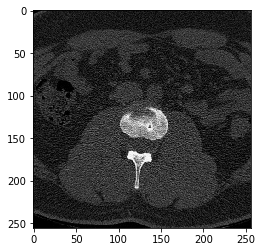

In [3]:
def load_data():
    filenames = []
    for root, dirs, files in os.walk('./data/x'):
        for name in files:
            filenames.append(os.path.join(root, name).split('/')[-1])

    num = len(filenames)
    size = 256
    data_shape = (num, size, size)
    X = np.zeros(data_shape)
    Y = np.zeros(data_shape)
    
    for i in range(num):
        f = filenames[i]
        img = np.array(cv2.imread('./data/x/' + f, 0))
        img2 = np.array(cv2.imread('./data/y/' + f, 0))
        X[i, :, :] = img
        Y[i, :, :] = img2
    
    X = X.reshape(num, size, size, 1)
    Y = Y.reshape(num, size, size, 1)
    
    X = X.astype('float32')
    Y = Y.astype('float32')
    
    X /= 255
    Y /= 255
    
    print(X.shape)
    
    return X, Y

X_train, Y_train = load_data()
print(X_train.shape)
plt.imshow(X_train[0,:,:,0], cmap='gray')

In [4]:
# load
model = load_model('./save/model.h5')

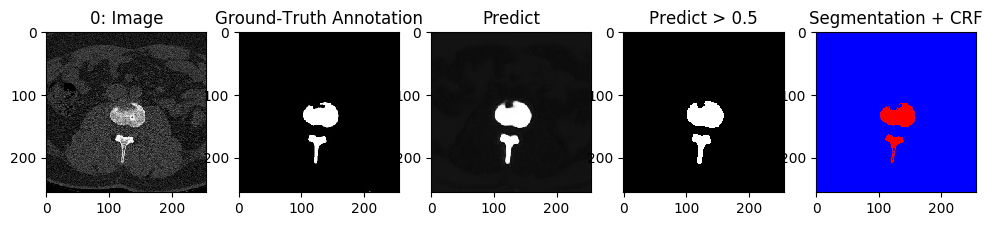

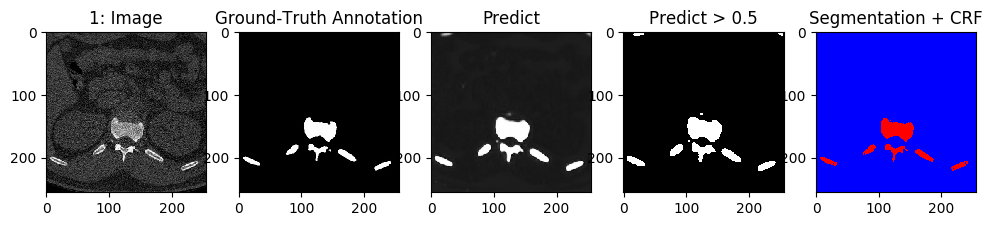

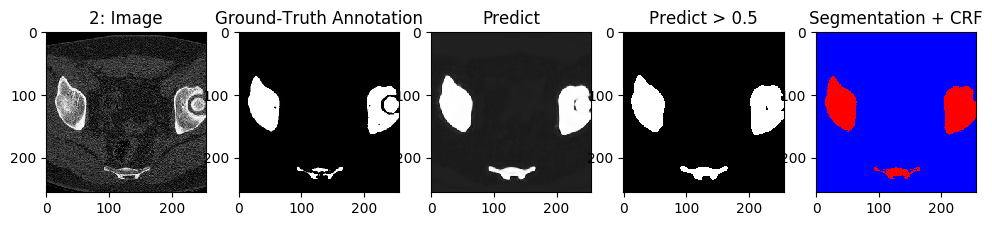

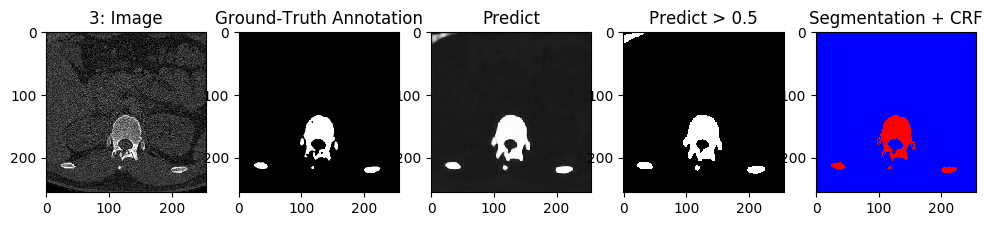

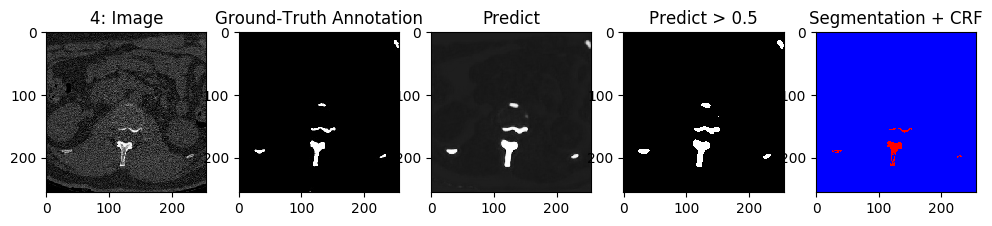

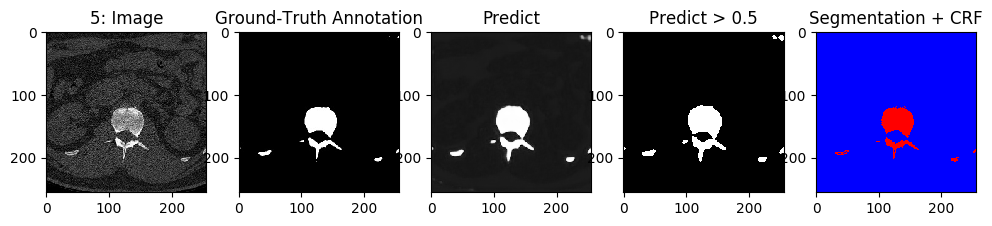

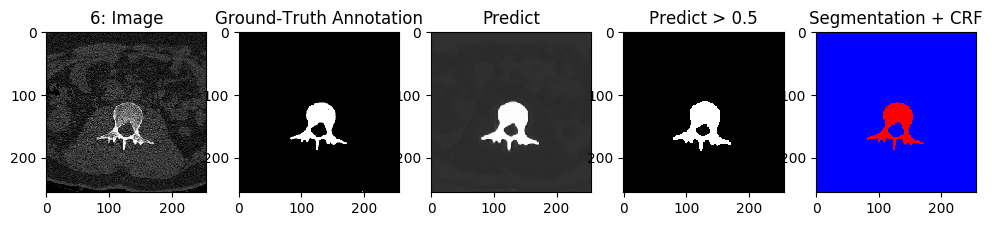

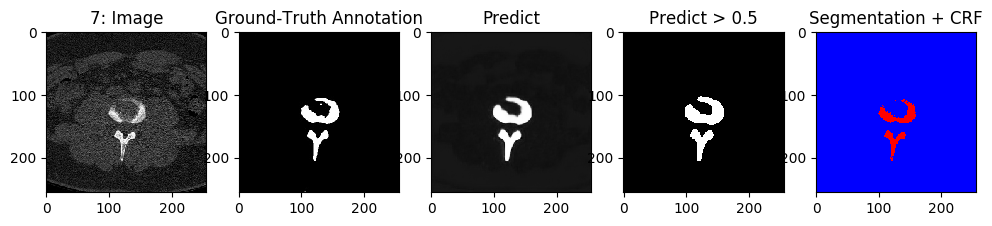

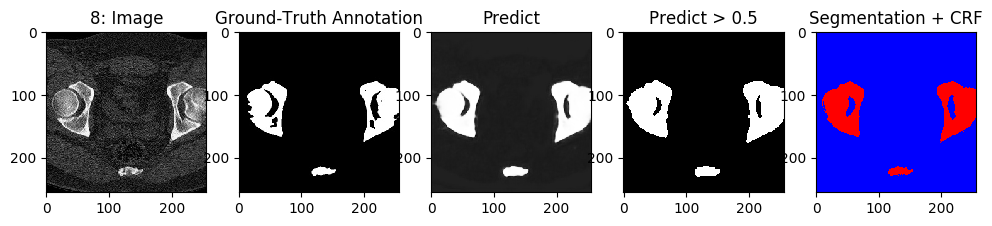

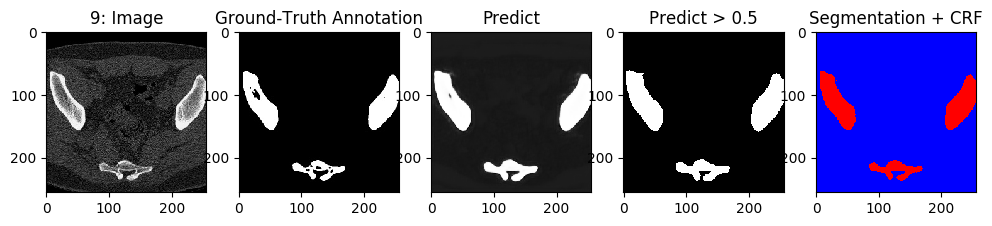

In [5]:
# https://github.com/lucasb-eyer/pydensecrf
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax
import skimage.io as io

size = 256
num = 10

def crf(n):
    for num in range(0, n):
        X = X_train[num:num+1]
        Y = Y_train[num:num+1]

        predict = model.predict(X)
        predict2 = predict > 0.5

        image = X[0,:,:,:]
        imagey = Y[0,:,:,0]

        final_probabilities = predict[0,:,:,:]
        final_probabilities = np.append(final_probabilities, 1 - final_probabilities, axis=2)
        final_probabilities = -np.log(final_probabilities)

        softmax = final_probabilities# 256, 256, 2

        softmax = np.transpose(softmax, (2, 0, 1))

        # unary

        unary = unary_from_softmax(softmax)# 2, 256, 256

        unary = np.ascontiguousarray(unary)
        unary = unary.reshape((2,-1))

        # d

        d = dcrf.DenseCRF2D(image.shape[0], image.shape[1], 2)

        d.setUnaryEnergy(unary)

        # create_pairwise_gaussian
        feats_g = create_pairwise_gaussian(sdims=(3, 3), shape=image.shape[:2])
        d.addPairwiseEnergy(feats_g, compat=15)

        # create_pairwise_bilateral
        feats_b = create_pairwise_bilateral(sdims=(99,99), schan=(0.01,), img=image, chdim=2)
        d.addPairwiseEnergy(feats_b, compat=10)

        Q = d.inference(5)

        res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

        plt.figure(num=None, figsize=(12, 15), dpi=100, facecolor='w', edgecolor='k')
        plt.subplot(151), plt.title(str(num) + ': Image'), plt.imshow(X.reshape(size,size), cmap='gray')
        plt.subplot(152), plt.title('Ground-Truth Annotation'), plt.imshow(Y.reshape(size,size), cmap='gray')
        plt.subplot(153), plt.title('Predict'), plt.imshow(predict.reshape(size,size), cmap='gray')
        plt.subplot(154), plt.title('Predict > 0.5'), plt.imshow(predict2.reshape(size,size), cmap='gray')
        plt.subplot(155), plt.title('Segmentation + CRF'), plt.imshow(res, cmap='bwr')

crf(10)